Tutorial convertido para jupyter tirado daqui: https://debuggercafe.com/traffic-sign-recognition-using-pytorch-and-deep-learning/


In [1]:
!pip install albumentations
!pip install pynvml

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Funções que vão ser uteis para visualizar os dados:

In [2]:
import torch
import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')
# def save_model(epochs, model, optimizer, criterion):
#     """
#     Function to save the trained model to disk.
#     """
#     torch.save({
#                 'epoch': epochs,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'loss': criterion,
#                 }, f"../outputs/model.pth")

def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to a variable.
    """
    model_checkpoint = {
        'epoch': epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': criterion
    }
    return model_checkpoint


def save_plots(train_acc, valid_acc, train_loss, valid_loss, model_name):
    """
    Function to save the loss and accuracy plots to disk in a single figure.
    """
    # Define the epoch range starting from 1 to match the list lengths
    epochs = range(1, len(train_acc) + 1)  # Adjust for epochs starting from 1

    # Create a figure with two subplots (2 rows, 1 column)
    fig, axes = plt.subplots(2, 1, figsize=(10, 14))  # Adjust the figure size as needed

    # Accuracy plot in the first subplot
    axes[0].plot(epochs, train_acc, color='green', linestyle='-', label='Train Accuracy')
    axes[0].plot(epochs, valid_acc, color='blue', linestyle='-', label='Validation Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title("Accuracy over Epochs")
    axes[0].legend()

    # Loss plot in the second subplot
    axes[1].plot(epochs, train_loss, color='orange', linestyle='-', label='Train Loss')
    axes[1].plot(epochs, valid_loss, color='red', linestyle='-', label='Validation Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].set_title("Loss over Epochs")
    axes[1].legend()

    # Adjust layout for better spacing
    plt.tight_layout()

    # Optionally save the plot to disk
    DIR = f"./OUTPUT/{model_name}_performance_metrics.png"
    plt.savefig(DIR, dpi=300, format='png')  # Save high-resolution PNG
    print(f"Plot saved to {DIR}")

    # Show the plot (optional, you may want to disable this if not necessary)
    plt.show()

/home/joao/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Codigo de preparação dos datasets, não podemos fazer flips horizontais nem verticais por se tratar de sinais de transito
A library de albumentations, parece muito legit

In [3]:
import albumentations as A
import numpy as np
import torch
from torchvision import datasets
from torch.utils.data import DataLoader, Subset, Dataset
from albumentations.pytorch import ToTensorV2
from PIL import Image
import pandas as pd

# Required constants
VALID_SPLIT = 0.1
RESIZE_TO = 224  # Image size of resize when applying transforms
BATCH_SIZE = 128  # 128
NUM_WORKERS = 4

class GTSRBDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        print(dataset)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image_np = np.array(image)

        if self.transform:
            transformed = self.transform(image=image_np)
            image = transformed['image']

        return image, label


# Training transforms with Albumentations
class TrainTransforms:
    def __init__(self, resize_to):
        self.transforms = A.Compose([
            A.Resize(resize_to, resize_to),
            A.RandomBrightnessContrast(),
            A.RandomFog(),
            A.RandomRain(),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
            ToTensorV2()
        ])

    def __call__(self, img):
        return self.transforms(image=np.array(img))['image']

# Validation transforms with Albumentations
class ValidTransforms:
    def __init__(self, resize_to):
        self.transforms = A.Compose([
            A.Resize(resize_to, resize_to),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
            ToTensorV2()
        ])

    def __call__(self, img):
        return self.transforms(image=np.array(img))['image']

# Test transforms with Albumentations
class TestTransforms:
    def __init__(self, resize_to):
        self.transforms = A.Compose([
            A.Resize(resize_to, resize_to),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
            ToTensorV2()
        ])

    def __call__(self, img):
        return self.transforms(image=np.array(img))['image']

def get_datasets():
    """
    Function to prepare the Datasets using Albumentations.
    Returns the training and validation datasets along with the class names.
    """
    # Download and load the training set without applying initial transforms
    dataset = datasets.GTSRB(
        root='./data',
        split='train',
        download=True,
    )

    test_dataset = datasets.GTSRB(
        root='./data',
        split='test',
        download=True,
    )

    # test_gt = pd.read_csv('./data/gtsrb/GT-final_test.csv', sep=';')

    # test_filePaths = test_gt['Filename'].tolist()

    # image_class_dict = dict(zip(test_gt['Filename'], test_gt['ClassId']))

    # Custom datasets with Albumentations transforms
    dataset_train_full = GTSRBDataset(
        dataset,
        transform=TrainTransforms(RESIZE_TO).transforms
    )

    dataset_valid_full = GTSRBDataset(
        dataset,
        transform=ValidTransforms(RESIZE_TO).transforms
    )

    dataset_test_full = GTSRBDataset(
        test_dataset,
        #test_filePaths,
        #image_class_dict,
        transform=TestTransforms(RESIZE_TO).transforms
    )

    dataset_size = len(dataset)
    valid_size = int(VALID_SPLIT * dataset_size)

    # Randomize the data indices
    indices = torch.randperm(len(dataset)).tolist()

    # Training and validation sets
    dataset_train = Subset(dataset_train_full, indices[:-valid_size])
    dataset_valid = Subset(dataset_valid_full, indices[-valid_size:])
    dataset_test = dataset_test_full

    return dataset_train, dataset_valid, dataset_test, list(range(43))  # GTSRB has 43 classes

def get_data_loaders(dataset_train, dataset_valid, dataset_test):
    """
    Prepares the training and validation data loaders.
    :param dataset_train: The training dataset.
    :param dataset_valid: The validation dataset.
    Returns the training and validation data loaders.
    """
    train_loader = DataLoader(
        dataset_train, batch_size=BATCH_SIZE,
        shuffle=True, num_workers=NUM_WORKERS,
        pin_memory=True
    )
    valid_loader = DataLoader(
        dataset_valid, batch_size=BATCH_SIZE,
        shuffle=False, num_workers=NUM_WORKERS,
        pin_memory=True
    )

    test_loader = DataLoader(
        dataset_test, batch_size=BATCH_SIZE,
        shuffle=False, num_workers=NUM_WORKERS,
        pin_memory=True
    )

    return train_loader, valid_loader, test_loader

/home/joao/.local/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
# Load the training and validation datasets
dataset_train, dataset_valid, dataset_test, dataset_classes = get_datasets()

# Load the training and validation data loaders
train_loader, valid_loader, test_loader = get_data_loaders(dataset_train, dataset_valid, dataset_test)

Dataset GTSRB
    Number of datapoints: 26640
    Root location: ./data
Dataset GTSRB
    Number of datapoints: 26640
    Root location: ./data
Dataset GTSRB
    Number of datapoints: 12630
    Root location: ./data


Agora para a parte da rede, vamos usar uma MobileNetV3.
Vamos poder dar load dos pre trained weights ou do nosso fine-tune ;)

In [5]:
import torchvision.models as models
import torch.nn as nn
import torchvision.models as models

def build_model(model_name="resnet18", pretrained=True, fine_tune=False, num_classes=10):
    model = None

    # Choose the model based on the provided model_name
    if model_name == "resnet18":
        print(f'[INFO]: Using ResNet18 model (pretrained = {pretrained})')
        weights = models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
        model = models.resnet18(weights=weights)

    elif model_name == "alexnet":
        print(f'[INFO]: Using AlexNet model (pretrained = {pretrained})')
        weights = models.AlexNet_Weights.IMAGENET1K_V1 if pretrained else None
        model = models.alexnet(weights=weights)

    elif model_name == "densenet121":
        print(f'[INFO]: Using DenseNet121 model (pretrained = {pretrained})')
        weights = models.DenseNet121_Weights.IMAGENET1K_V1 if pretrained else None
        model = models.densenet121(weights=weights)

    elif model_name == "mobilenetv3":
        print(f'[INFO]: Using MobileNetV3 model (pretrained = {pretrained})')
        weights = models.MobileNet_V3_Large_Weights.IMAGENET1K_V1 if pretrained else None
        model = models.mobilenet_v3_large(weights=weights)

    else:
        raise ValueError(f"Model {model_name} is not supported. Choose from ['resnet18', 'alexnet', 'densenet121', 'mobilenetv3'].")

    # Fine-tuning (if enabled)
    if fine_tune:
        print('[INFO]: Fine-tuning all layers...')
        for params in model.parameters():
            params.requires_grad = True
    else:
        print('[INFO]: Freezing hidden layers...')
        for params in model.parameters():
            params.requires_grad = False

    # Update the classification layer to match the number of classes
    if hasattr(model, 'classifier'):
        # For models like AlexNet, DenseNet121, and MobileNetV3, we modify the classifier
        if isinstance(model.classifier, nn.Sequential):
            # For MobileNetV3, change the last fully connected layer
            if model_name == "mobilenetv3":
                model.classifier[3] = nn.Linear(in_features=model.classifier[3].in_features, out_features=num_classes)
            # Tive de especificar, porque a Linear esta nesta posicao para o mobilenetv3
            else:
              model.classifier[6] = nn.Linear(in_features=model.classifier[6].in_features, out_features=num_classes)

        else:
            model.classifier = nn.Linear(in_features=model.classifier.in_features, out_features=num_classes)
    elif hasattr(model, 'fc'):
        # For ResNet, we modify the final fully connected layer (fc)
        model.fc = nn.Linear(in_features=model.fc.in_features, out_features=num_classes)
    else:
        raise NotImplementedError(f"Model {model_name} does not have a classification layer")

    return model


Agora vamos vai-se criar um environment de treino:

In [6]:
import torch.optim as optim
import time
from tqdm.auto import tqdm  #library para mostrar as barrinhas nice

seed = 42

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True


# Training function.
def train(
    model, trainloader, optimizer,
    criterion, scheduler=None, epoch=None):

    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    iters = len(trainloader)

    # Initialize the GPU metrics dictionary
    train_gpu_metrics = {
        "free_memory_MB": 0.0,
        "total_memory_MB": 0.0,
        "memory_frag": 0.0,
        "utilization_percent": 0.0,
        "power_draw_W": 0.0,
        "temperature_C": 0.0
    }


    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        # Forward pass.
        outputs = model(image)

        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()

        # Backpropagation.
        loss.backward()
        # Update the weights.
        optimizer.step()

        # Metricas da GPU
        current_metrics = get_gpu_metrics(device)
        for key in train_gpu_metrics:
            train_gpu_metrics[key] += current_metrics.get(key, 0.0)

        if scheduler is not None:
            scheduler.step(epoch + i / iters)

    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))

    epoch_gpu_metrics = {key: value / counter for key, value in train_gpu_metrics.items()}

    return epoch_loss, epoch_acc, epoch_gpu_metrics


# Validation function.
def validate(model, testloader, criterion, class_names):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0

    # Initialize the GPU metrics dictionary
    valid_gpu_metrics = {
        "free_memory_MB": 0.0,
        "total_memory_MB": 0.0,
        "memory_frag": 0.0,
        "utilization_percent": 0.0,
        "power_draw_W": 0.0,
        "temperature_C": 0.0
    }

    # We need two lists to keep track of class-wise accuracy.
    class_correct = list(0. for i in range(len(class_names)))
    class_total = list(0. for i in range(len(class_names)))
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1

            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)

            # GPU metrics after forward pass
            # Metricas da GPU
            current_metrics = get_gpu_metrics(device)
            for key in valid_gpu_metrics:
                valid_gpu_metrics[key] += current_metrics.get(key, 0.0)

            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
            # Calculate the accuracy for each class.
            correct  = (preds == labels).squeeze()
            for i in range(len(preds)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))

    epoch_gpu_metrics = {key: value / counter for key, value in valid_gpu_metrics.items()}

    # Print the accuracy for each class after every epoch.
    print('\n')
    for i in range(len(class_names)):
        print(f"Accuracy of class {class_names[i]}: {100*class_correct[i]/class_total[i]}")
    print('\n')
    return epoch_loss, epoch_acc, epoch_gpu_metrics


Getting the gpu information to understand how could be possible better to configure it

In [7]:
def get_cuda_info(device_index=0):
    properties = torch.cuda.get_device_properties(device_index)

    # Device properties
    device_info = {
        "Device Name": properties.name,
        "Total Memory (MB)": properties.total_memory / 1024**2,
        "Compute Capability": f"{properties.major}.{properties.minor}",
        "Multiprocessor Count": properties.multi_processor_count
    }

    return device_info

cuda_info = get_cuda_info()
for key, value in cuda_info.items():
    print(f"{key}: {value}")

Device Name: NVIDIA GeForce RTX 4060 Ti
Total Memory (MB): 15969.875
Compute Capability: 8.9
Multiprocessor Count: 34


# **CUDA related functions**


In [8]:
import pynvml

def get_gpu_metrics(device_index=0):
    """
    Retrieves GPU metrics: memory allocated, reserved, utilization, power draw, and temperature.

    Args:
        device_index: The index of the GPU device.

    Returns:
        A dictionary containing the GPU metrics. Returns an empty dictionary if CUDA is not available.
    """
    if not torch.cuda.is_available():
        print("CUDA is not available.")
        return {}

    try:
        free_mem, total_mem = torch.cuda.mem_get_info()
        memory_frag = (total_mem - free_mem - torch.cuda.memory_allocated()) / total_mem
        #torch.cuda.memory_snapshot()
        # memory_allocated = torch.cuda.free_memory(device_index) / (1024**2)  # MB
        # memory_reserved = torch.cuda.memory_reserved(device_index) / (1024**2)   # MB
        utilization = torch.cuda.utilization(device_index)  # Percentage
        power_draw = torch.cuda.power_draw(device_index)  # Power draw in Watts
        temperature = torch.cuda.temperature(device_index)  # Temperature in Celsius
        

        gpu_metrics = {
            "free_memory_MB": free_mem / (1024**2),
            "total_memory_MB": total_mem / (1024**2),
            "memory_frag": memory_frag,
            "utilization_percent": utilization,
            "power_draw_W": power_draw / 1000,
            "temperature_C": temperature
        }
        return gpu_metrics
    except Exception as e:
        print(f"Error getting GPU metrics: {e}")
        return {}

Esta função demonstra os parametros da GPU

In [9]:

def plot_gpu_metrics(gpu_metrics_history, model_name, type):
    """
    Displays GPU metrics (memory, power, temperature) over time in a graph.

    Args:
        gpu_metrics_history: A list of dictionaries, where each dictionary contains GPU metrics at a specific time step.
    """

    if not gpu_metrics_history:
        print("No GPU metrics data available.")
        return

    # Check the length of gpu_metrics_history and print it for debugging
    print(f"Total epochs of GPU metrics: {len(gpu_metrics_history)}")
    print(f"GPU metrics for the first epoch: {gpu_metrics_history[0]}")

    # Ensure we're getting the expected data
    epochs = range(1, len(gpu_metrics_history) + 1)  #Como so se calcula no fim, so temos informação do final da eṕoca, não existe epoca 0
    print(f"Epochs: {list(epochs)}")  # Print epoch numbers for debugging

    # Extract metrics for plotting
    free_memory = [metrics['free_memory_MB'] for metrics in gpu_metrics_history]
    total_memory = [metrics['total_memory_MB'] for metrics in gpu_metrics_history]
    memory_frag = [metrics["memory_frag"] for metrics in gpu_metrics_history]
    utilization = [metrics["utilization_percent"] for metrics in gpu_metrics_history]
    power_draw = [metrics["power_draw_W"] for metrics in gpu_metrics_history]
    temperature = [metrics["temperature_C"] for metrics in gpu_metrics_history]
    

    # Check if all lists have the same length
    print(f"Length of free_memory: {len(free_memory)}")
    print(f"Length of free_memory: {len(free_memory)}")
    print(f"Length of memory_frag: {len(memory_frag)}")
    print(f"Length of utilization: {len(utilization)}")
    print(f"Length of power_draw: {len(power_draw)}")
    print(f"Length of temperature: {len(temperature)}")

    # Create subplots
    fig, axes = plt.subplots(4, 1, figsize=(10, 15))

    # Plot memory usage
    axes[0].plot(epochs, free_memory, label='Free Memory (MB)')
    axes[0].plot(epochs, total_memory, label='Total Memory (MB)')
    # axes[0].plot(epochs, memory_frag, label='Fragemented Memory (MB)')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Memory (MB)')
    axes[0].set_title('GPU Memory Usage')
    axes[2].set_ylim(0, None)
    axes[0].legend()

    # Plot power draw
    axes[1].plot(epochs, power_draw, label='Power Draw (W)')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Power (W)')
    axes[1].set_title('GPU Power Draw')
    axes[1].legend()

    # Plot %Usage
    axes[2].plot(epochs, utilization, label='GPU Usage (%)')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Usage (%)')
    axes[2].set_title('GPU Usage')
    axes[2].set_ylim(0, 100)  # Limit y-axis to 0-100
    axes[2].legend()

    # Plot temperature
    axes[3].plot(epochs, temperature, label='Temperature (°C)')
    axes[3].set_xlabel('Epoch')
    axes[3].set_ylabel('Temperature (°C)')
    axes[3].set_title('GPU Temperature')
    axes[3].legend()

    plt.tight_layout()  # Adjust layout for better spacing

    DIR=f"./OUTPUT/{model_name}_{type}_gpu_metrics.png"
    plt.savefig(DIR, dpi=300, format='png')  # Save high-resolution PNG
    print(f"Plot saved to {DIR}")

    plt.show()

Aqui onde se vai executar tudo, simplesmente so temos de definir os parametros no args.

In [10]:
import gc

if 'model' in globals():
    del model
else:
    print("Model not defined.")

# Garbage Collector, porque a GPU estava entupida
gc.collect()
# Limpar a cache de alguma coisa
torch.cuda.empty_cache()

Model not defined.


# **TRAIN THE MODEL**


Dataset GTSRB
    Number of datapoints: 26640
    Root location: ./data
Dataset GTSRB
    Number of datapoints: 26640
    Root location: ./data
Dataset GTSRB
    Number of datapoints: 12630
    Root location: ./data
[INFO]: Number of training images: 23976
[INFO]: Number of validation images: 2664
[INFO]: Class names: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]

Computation device: cuda
Learning rate: 0.001
Epochs to train for: 5

[INFO]: Using AlexNet model (pretrained = True)
[INFO]: Fine-tuning all layers...
57,180,011 total parameters.
57,180,011 training parameters.
[INFO]: Epoch 1 of 5
Current learning rate: 0.001
Training


  0%|          | 0/188 [00:00<?, ?it/s]

Validation


  0%|          | 0/21 [00:00<?, ?it/s]



Accuracy of class 0: 0.0
Accuracy of class 1: 52.77777777777778
Accuracy of class 2: 27.63157894736842
Accuracy of class 3: 0.0
Accuracy of class 4: 2.127659574468085
Accuracy of class 5: 85.31468531468532
Accuracy of class 6: 21.21212121212121
Accuracy of class 7: 0.0
Accuracy of class 8: 4.705882352941177
Accuracy of class 9: 92.78350515463917
Accuracy of class 10: 96.8
Accuracy of class 11: 9.67741935483871
Accuracy of class 12: 100.0
Accuracy of class 13: 98.63945578231292
Accuracy of class 14: 100.0
Accuracy of class 15: 100.0
Accuracy of class 16: 66.66666666666667
Accuracy of class 17: 100.0
Accuracy of class 18: 15.492957746478874
Accuracy of class 19: 0.0
Accuracy of class 20: 0.0
Accuracy of class 21: 0.0
Accuracy of class 22: 0.0
Accuracy of class 23: 0.0
Accuracy of class 24: 0.0
Accuracy of class 25: 93.39622641509433
Accuracy of class 26: 56.81818181818182
Accuracy of class 27: 0.0
Accuracy of class 28: 0.0
Accuracy of class 29: 0.0
Accuracy of class 30: 0.0
Accuracy of

  0%|          | 0/188 [00:00<?, ?it/s]

Validation


  0%|          | 0/21 [00:00<?, ?it/s]



Accuracy of class 0: 85.71428571428571
Accuracy of class 1: 92.36111111111111
Accuracy of class 2: 94.07894736842105
Accuracy of class 3: 88.57142857142857
Accuracy of class 4: 93.61702127659575
Accuracy of class 5: 73.42657342657343
Accuracy of class 6: 96.96969696969697
Accuracy of class 7: 54.0
Accuracy of class 8: 80.0
Accuracy of class 9: 92.78350515463917
Accuracy of class 10: 100.0
Accuracy of class 11: 95.6989247311828
Accuracy of class 12: 99.33774834437087
Accuracy of class 13: 99.31972789115646
Accuracy of class 14: 100.0
Accuracy of class 15: 100.0
Accuracy of class 16: 100.0
Accuracy of class 17: 100.0
Accuracy of class 18: 92.95774647887323
Accuracy of class 19: 100.0
Accuracy of class 20: 92.3076923076923
Accuracy of class 21: 38.095238095238095
Accuracy of class 22: 85.71428571428571
Accuracy of class 23: 100.0
Accuracy of class 24: 90.0
Accuracy of class 25: 90.56603773584905
Accuracy of class 26: 68.18181818181819
Accuracy of class 27: 90.9090909090909
Accuracy of c

  0%|          | 0/188 [00:00<?, ?it/s]

Validation


  0%|          | 0/21 [00:00<?, ?it/s]



Accuracy of class 0: 92.85714285714286
Accuracy of class 1: 97.91666666666667
Accuracy of class 2: 99.34210526315789
Accuracy of class 3: 89.52380952380952
Accuracy of class 4: 99.29078014184397
Accuracy of class 5: 84.61538461538461
Accuracy of class 6: 96.96969696969697
Accuracy of class 7: 91.0
Accuracy of class 8: 72.94117647058823
Accuracy of class 9: 100.0
Accuracy of class 10: 100.0
Accuracy of class 11: 100.0
Accuracy of class 12: 100.0
Accuracy of class 13: 100.0
Accuracy of class 14: 100.0
Accuracy of class 15: 100.0
Accuracy of class 16: 100.0
Accuracy of class 17: 100.0
Accuracy of class 18: 100.0
Accuracy of class 19: 94.44444444444444
Accuracy of class 20: 92.3076923076923
Accuracy of class 21: 95.23809523809524
Accuracy of class 22: 100.0
Accuracy of class 23: 100.0
Accuracy of class 24: 100.0
Accuracy of class 25: 98.11320754716981
Accuracy of class 26: 88.63636363636364
Accuracy of class 27: 100.0
Accuracy of class 28: 96.875
Accuracy of class 29: 100.0
Accuracy of c

  0%|          | 0/188 [00:00<?, ?it/s]

Validation


  0%|          | 0/21 [00:00<?, ?it/s]



Accuracy of class 0: 92.85714285714286
Accuracy of class 1: 99.30555555555556
Accuracy of class 2: 99.34210526315789
Accuracy of class 3: 97.14285714285714
Accuracy of class 4: 97.87234042553192
Accuracy of class 5: 93.7062937062937
Accuracy of class 6: 100.0
Accuracy of class 7: 84.0
Accuracy of class 8: 96.47058823529412
Accuracy of class 9: 98.96907216494846
Accuracy of class 10: 100.0
Accuracy of class 11: 100.0
Accuracy of class 12: 99.33774834437087
Accuracy of class 13: 100.0
Accuracy of class 14: 100.0
Accuracy of class 15: 100.0
Accuracy of class 16: 100.0
Accuracy of class 17: 100.0
Accuracy of class 18: 100.0
Accuracy of class 19: 100.0
Accuracy of class 20: 96.15384615384616
Accuracy of class 21: 100.0
Accuracy of class 22: 100.0
Accuracy of class 23: 100.0
Accuracy of class 24: 95.0
Accuracy of class 25: 100.0
Accuracy of class 26: 93.18181818181819
Accuracy of class 27: 100.0
Accuracy of class 28: 100.0
Accuracy of class 29: 100.0
Accuracy of class 30: 100.0
Accuracy of

  0%|          | 0/188 [00:00<?, ?it/s]

Validation


  0%|          | 0/21 [00:00<?, ?it/s]



Accuracy of class 0: 92.85714285714286
Accuracy of class 1: 100.0
Accuracy of class 2: 100.0
Accuracy of class 3: 100.0
Accuracy of class 4: 98.58156028368795
Accuracy of class 5: 95.1048951048951
Accuracy of class 6: 100.0
Accuracy of class 7: 94.0
Accuracy of class 8: 94.11764705882354
Accuracy of class 9: 100.0
Accuracy of class 10: 97.6
Accuracy of class 11: 100.0
Accuracy of class 12: 100.0
Accuracy of class 13: 100.0
Accuracy of class 14: 100.0
Accuracy of class 15: 100.0
Accuracy of class 16: 100.0
Accuracy of class 17: 100.0
Accuracy of class 18: 98.59154929577464
Accuracy of class 19: 100.0
Accuracy of class 20: 96.15384615384616
Accuracy of class 21: 100.0
Accuracy of class 22: 100.0
Accuracy of class 23: 100.0
Accuracy of class 24: 100.0
Accuracy of class 25: 99.05660377358491
Accuracy of class 26: 93.18181818181819
Accuracy of class 27: 100.0
Accuracy of class 28: 100.0
Accuracy of class 29: 100.0
Accuracy of class 30: 100.0
Accuracy of class 31: 100.0
Accuracy of class 3

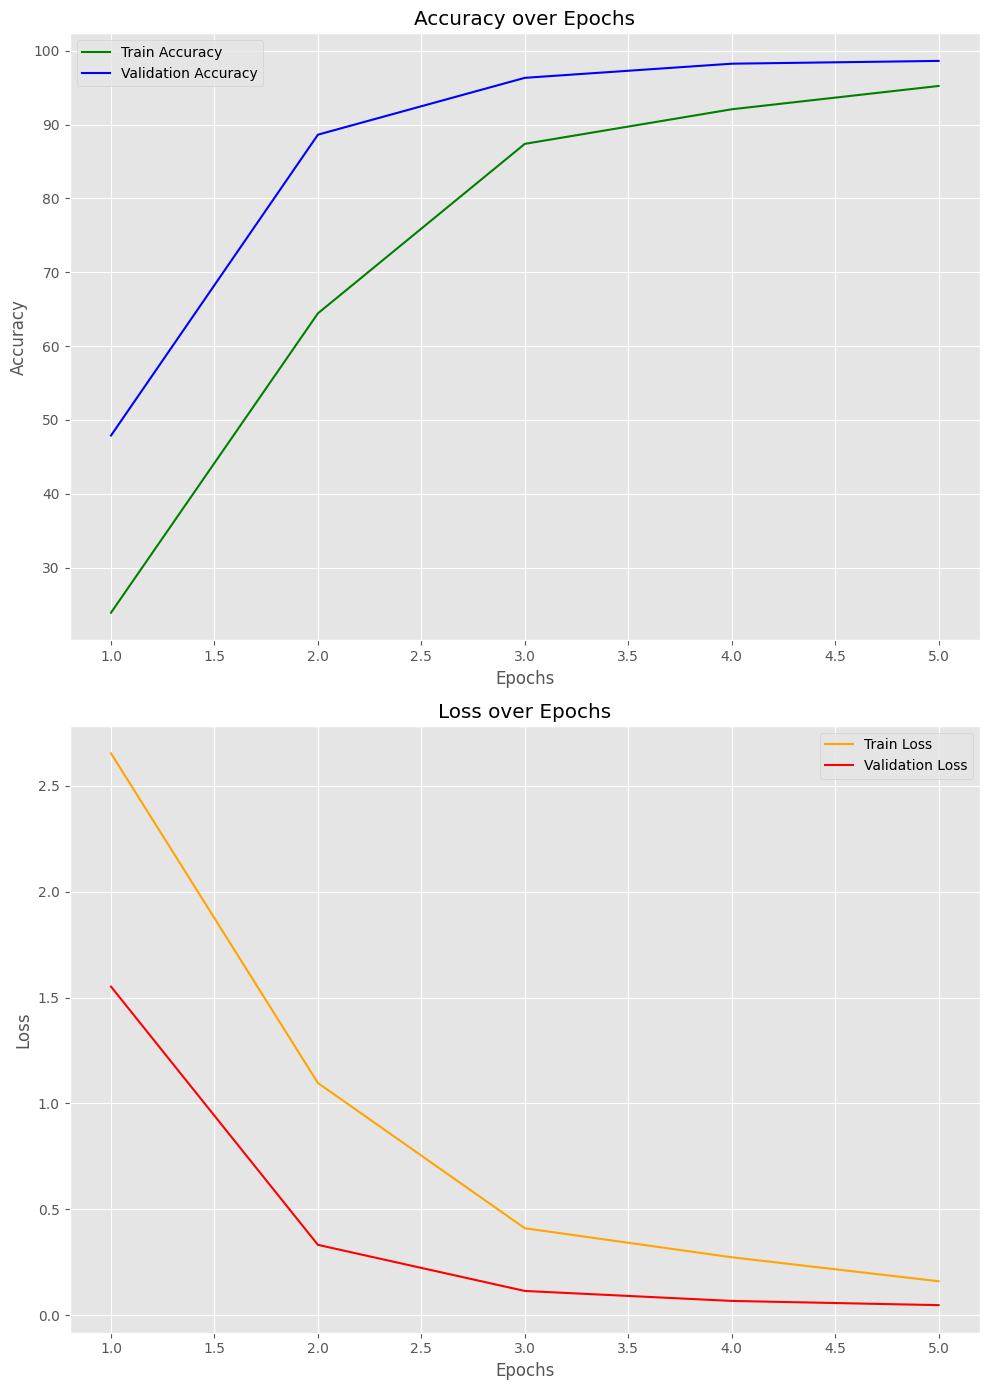

TRAINING COMPLETE


In [11]:

# Dicionario com os parametros, escolher a rede e configurar aqui!!!!!
args = {
    'model_name': "alexnet",
    'epochs': 5,
    'learning_rate': 0.001,
    'pretrained': True,
    'fine_tune': True
}

# Load the training and validation datasets
dataset_train, dataset_valid, dataset_test, dataset_classes = get_datasets()
print(f"[INFO]: Number of training images: {len(dataset_train)}")
print(f"[INFO]: Number of validation images: {len(dataset_valid)}")
print(f"[INFO]: Class names: {dataset_classes}\n")

# Load the training and validation data loaders
train_loader, valid_loader, test_loader = get_data_loaders(dataset_train, dataset_valid, dataset_test)

# Learning parameters
lr = args['learning_rate']
epochs = args['epochs']
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")
print(f"Learning rate: {lr}")
print(f"Epochs to train for: {epochs}\n")

# Load the model
model = build_model(
    model_name=args['model_name'],
    pretrained=args['pretrained'],
    fine_tune=args['fine_tune'],
    num_classes=len(dataset_classes)
).to(device)

# Total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

# Optimizer, loss function, and scheduler
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,
    T_mult=1,
    #verbose=True
)

# Lists to keep track of losses and accuracies
train_loss, valid_loss, test_loss = [], [], []
train_acc, valid_acc, test_acc = [], [], []
train_gpu_metrics, valid_gpu_metrics = [], []

for epoch in range(epochs):
  print(f"[INFO]: Epoch {epoch+1} of {epochs}")
  print(f"Current learning rate: {scheduler.get_last_lr()[0]}")

  train_epoch_loss, train_epoch_acc, train_epoch_gpu_metrics = train(
      model, train_loader,
      optimizer, criterion,
      scheduler=scheduler, epoch=epoch
  )

  # Append dos stats do treino
  train_acc.append(train_epoch_acc)
  train_loss.append(train_epoch_loss)
  train_gpu_metrics.append(train_epoch_gpu_metrics)


  # Validação e append
  valid_epoch_loss, valid_epoch_acc, valid_epoch_gpu_metrics = validate(model, valid_loader, criterion, dataset_classes)
  valid_loss.append(valid_epoch_loss)
  valid_acc.append(valid_epoch_acc)
  valid_gpu_metrics.append(valid_epoch_gpu_metrics)

  print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
  print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
  print('-'*50)
  # time.sleep(5)
  # print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))


# Save the trained model weights
save_model(epochs, model, optimizer, criterion)
# # Plot the gpu metrics
# plot_gpu_metrics(train_gpu_metrics)
# plot_gpu_metrics(valid_gpu_metrics)
# # Save the loss and accuracy plots
save_plots(train_acc, valid_acc, train_loss, valid_loss, args["model_name"])
print('TRAINING COMPLETE')

Para fazer debug ao plot por causa da epoca 0

Total epochs of GPU metrics: 5
GPU metrics for the first epoch: {'free_memory_MB': 13357.212765957447, 'total_memory_MB': 15969.875, 'memory_frag': 0.10325358901074849, 'utilization_percent': 88.45744680851064, 'power_draw_W': 97.56680851063834, 'temperature_C': 49.170212765957444}
Epochs: [1, 2, 3, 4, 5]
Length of free_memory: 5
Length of free_memory: 5
Length of memory_frag: 5
Length of utilization: 5
Length of power_draw: 5
Length of temperature: 5
Plot saved to ./OUTPUT/alexnet_train_gpu_metrics.png


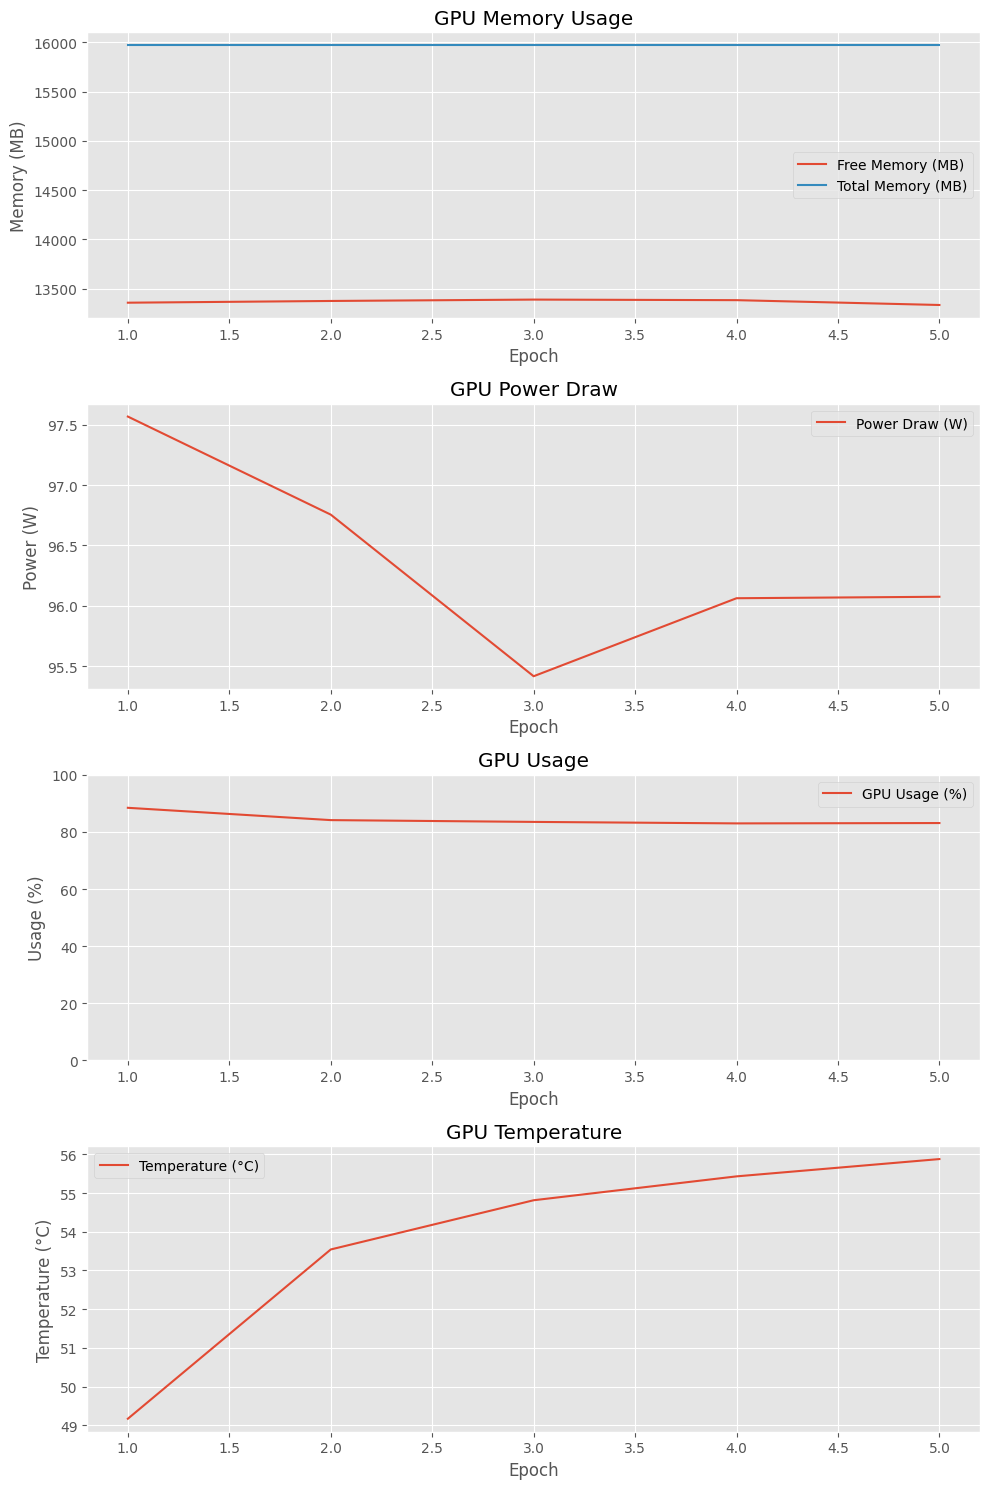

Total epochs of GPU metrics: 5
GPU metrics for the first epoch: {'free_memory_MB': 13838.220238095239, 'total_memory_MB': 15969.875, 'memory_frag': 0.07309739635107247, 'utilization_percent': 73.47619047619048, 'power_draw_W': 92.72980952380952, 'temperature_C': 49.04761904761905}
Epochs: [1, 2, 3, 4, 5]
Length of free_memory: 5
Length of free_memory: 5
Length of memory_frag: 5
Length of utilization: 5
Length of power_draw: 5
Length of temperature: 5
Plot saved to ./OUTPUT/alexnet_valid_gpu_metrics.png


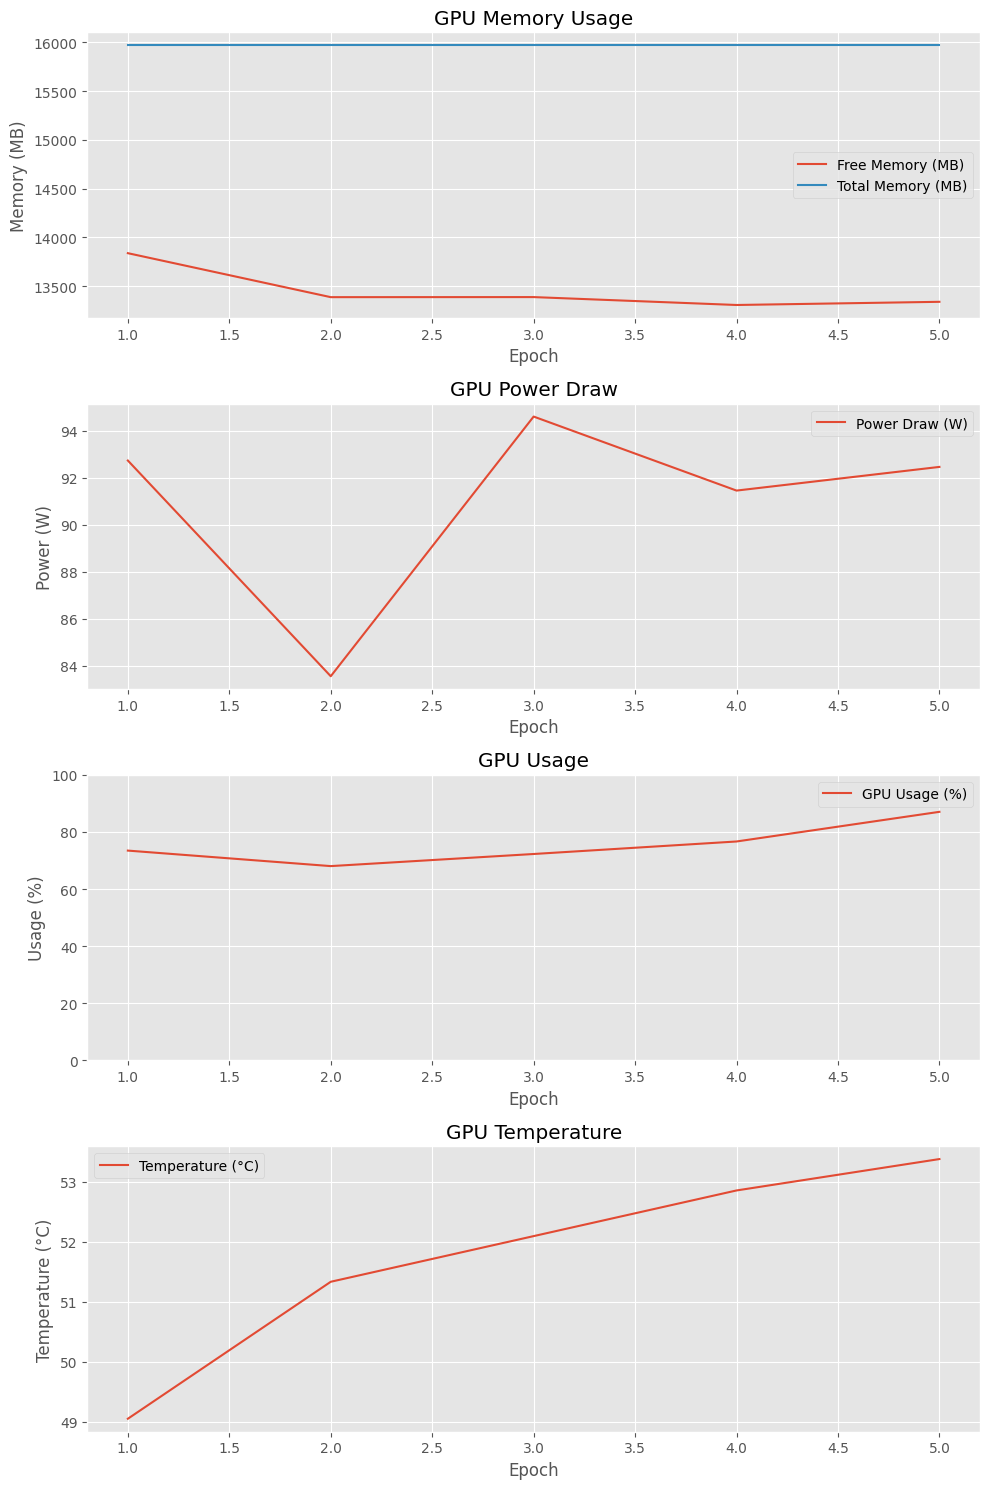

Metrics plotted


In [12]:
# Plot the gpu metrics
plot_gpu_metrics(train_gpu_metrics, args['model_name'], "train")
plot_gpu_metrics(valid_gpu_metrics, args['model_name'], "valid")
print('Metrics plotted')